<a href="https://colab.research.google.com/github/guillaumetougas/sbl_hyperspectral_ai/blob/main/02_scripts/sbl_hyperspec_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D-CNN model from hyperspectral data


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torchvision as tv
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchaudio as ta
!pip install rasterio
import rasterio as rio

###Load preprocessed HS data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [56]:
#Load HS data with geopandas
smoothed_data=gpd.read_file("/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/sbl_smoothed_spectra.gpkg")

#filtered_data
# Calculate value counts for each label
label_counts = smoothed_data['Label'].value_counts()

# Filter out labels with count < 100 and "Acer"
filtered_data = smoothed_data[
    smoothed_data['Label'].apply(lambda label: label_counts[label] >= 100 and label != "Acer")
]

#isolate spectral data and prepare with rasterio
spectral_data_labeled = filtered_data.drop(columns=['geometry']).values
print(np.shape(spectral_data_labeled))
#print(spectral_data_labeled[:5])

spectral_data = spectral_data_labeled[:, 1:243]
print(spectral_data[:,241])

(17683, 246)
[0.06830659106593368 0.0711628405797041 0.05798870468661341 ...
 0.0002695426312816876 0.0002724091850176913 0.0]


### Create the 1D-CNN model

In [57]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Example hyperspectral data (N samples, C spectral bands)
# Replace this with your actual data
N, C = 21696, 242  # Example: 21696 pixels, 242 bands
#X = spectral_data
#Y = labels

# Normalization (recommended for pretrained generic models like 1D CNN)
spectral_data = (spectral_data - np.min(spectral_data)) / (np.max(spectral_data) - np.min(spectral_data))

# Ensure spectral_data has a numeric dtype before converting to tensor
spectral_data = spectral_data.astype(np.float32)  # or np.float64

labels = filtered_data['Label']
print(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectral_data, labels, test_size=0.2, random_state=42)

# 1. Create train/val indices instead of directly splitting
dataset_size = len(spectral_data)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20% for validation
np.random.shuffle(indices)  # Shuffle indices randomly
train_indices, val_indices = indices[split:], indices[:split]

# 2. Separate data using the indices
X_train, X_val = spectral_data[train_indices], spectral_data[val_indices]
y_train, y_val = labels.iloc[train_indices], labels.iloc[val_indices]

# 3. Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# 4. Create PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_val = torch.tensor(y_train_encoded, dtype=torch.long), torch.tensor(y_val_encoded, dtype=torch.long)

0         BEPA
1        Picea
2         ACSA
3         ABBA
4         ABBA
         ...  
18337     ACRU
18338     THOC
18339    Picea
18340    Picea
18341     Mort
Name: Label, Length: 17683, dtype: object


In [58]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a 1D CNN for hyperspectral data classification
class HyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(HyperspectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        fc1_input_size = 128 * input_channels #output size of conv2 x number of bands
        self.fc1 = nn.Linear(fc1_input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = self.pool(x)

        # Check if x has 3 dimensions before accessing x.size(2)
        #if x.dim() == 3:
        fc1_input_size = x.size(1) * x.size(2)
        #else:
            # If x has only 2 dimensions, calculate fc1_input_size accordingly
        #    fc1_input_size = x.size(1)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Adjust fc1 input size to match the actual flattened size
        self.fc1 = nn.Linear(fc1_input_size, 256)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

###Set up focal loss function for class imbalance

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

###Model parameters and optimizer and loss function set up





In [60]:
# Model parameters
input_channels = C
num_classes = len(torch.unique(y_train))  # Number of unique labels
# Reshape for 1D CNN - Assuming spectral bands are in rows
# Transpose to have samples in rows and spectral bands in columns
X_train = X_train.T
X_val = X_val.T

# Reshape X_train before the loop
X_train_reshaped = X_train.T[:, :, None]  # add extra dimension to have a 3D tensor

# Create train_dataset and train_loader outside the loop
train_dataset = torch.utils.data.TensorDataset(X_train_reshaped, y_train)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Initialize the model, loss function, and optimizer
model = HyperspectralCNN(input_channels, num_classes)
criterion = FocalLoss(gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)


###Train the model

In [ ]:
#Visualize model performance
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Training loop
num_epochs = 100

epoch_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
  epoch_loss = 0.0

  #training phase
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, target)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()  # Accumulate batch loss

    #Print loss every 500 iterations
    if (batch_idx + 1) % 500 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{batch_idx+1}], Loss: {loss.item():.4f}')

  epoch_losses.append(epoch_loss / len(train_loader)) # Average loss over all batches in the epoch

  model.eval()
  with torch.no_grad():
    # Calculate and store training F1-score
    train_outputs = model(X_train_reshaped)
    _, predicted_train = torch.max(train_outputs, 1)
    train_f1 = f1_score(y_train.cpu(), predicted_train.cpu(), average='weighted')

    # Reshape validation data and calculate validation F1-score
    X_val_reshaped = X_val.T[:, :, None]
    val_outputs = model(X_val_reshaped)
    _, predicted_val = torch.max(val_outputs, 1)
    val_f1 = f1_score(y_val.cpu(), predicted_val.cpu(), average='weighted')

  #append f1-scores
  train_f1_scores.append(train_f1)
  val_f1_scores.append(val_f1)

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses[-1]:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

Epoch [1/100], Loss: 1.5880, Train F1: 0.1159, Val F1: 0.1369
Epoch [2/100], Loss: 1.4863, Train F1: 0.1866, Val F1: 0.1369
Epoch [3/100], Loss: 1.4365, Train F1: 0.1158, Val F1: 0.1124
Epoch [4/100], Loss: 1.4019, Train F1: 0.1795, Val F1: 0.1763
Epoch [5/100], Loss: 1.3771, Train F1: 0.2750, Val F1: 0.2597
Epoch [6/100], Loss: 1.3539, Train F1: 0.2110, Val F1: 0.2480
Epoch [7/100], Loss: 1.3356, Train F1: 0.2288, Val F1: 0.2631
Epoch [8/100], Loss: 1.3179, Train F1: 0.2266, Val F1: 0.2473
Epoch [9/100], Loss: 1.3082, Train F1: 0.2010, Val F1: 0.2099
Epoch [10/100], Loss: 1.2954, Train F1: 0.2641, Val F1: 0.2149
Epoch [11/100], Loss: 1.2804, Train F1: 0.2020, Val F1: 0.2150
Epoch [12/100], Loss: 1.2714, Train F1: 0.2143, Val F1: 0.1930
Epoch [13/100], Loss: 1.2642, Train F1: 0.2002, Val F1: 0.1714
Epoch [14/100], Loss: 1.2520, Train F1: 0.2950, Val F1: 0.2781
Epoch [15/100], Loss: 1.2473, Train F1: 0.2538, Val F1: 0.2740
Epoch [16/100], Loss: 1.2403, Train F1: 0.2014, Val F1: 0.3019
E

###Evaluate the model

In [62]:
# Evaluate the model on a test dataset
model.eval()
with torch.no_grad():
   # Reshape the validation data to add an extra dimension for sequence length
    X_val_reshaped = X_val.T[:, :, None]

    # Create a DataLoader for the validation set
    val_dataset = torch.utils.data.TensorDataset(X_val_reshaped, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for evaluation

    total_correct = 0
    total_samples = 0

    for data, target in val_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.4567


###Visualize model performance

In [63]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

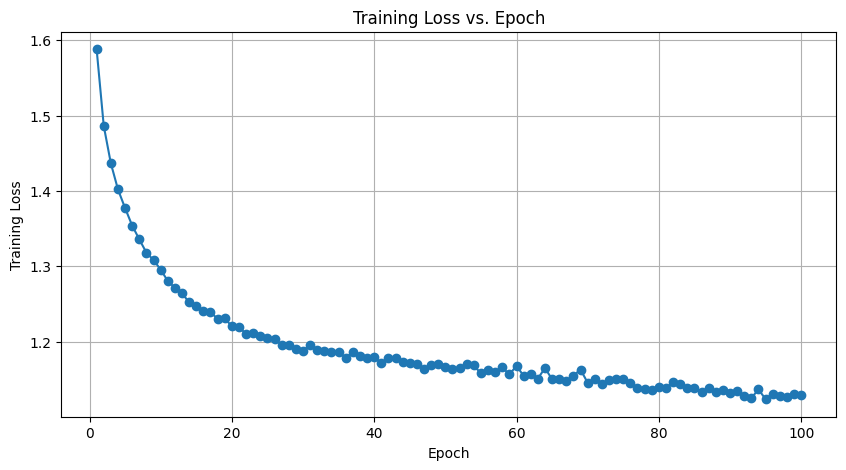

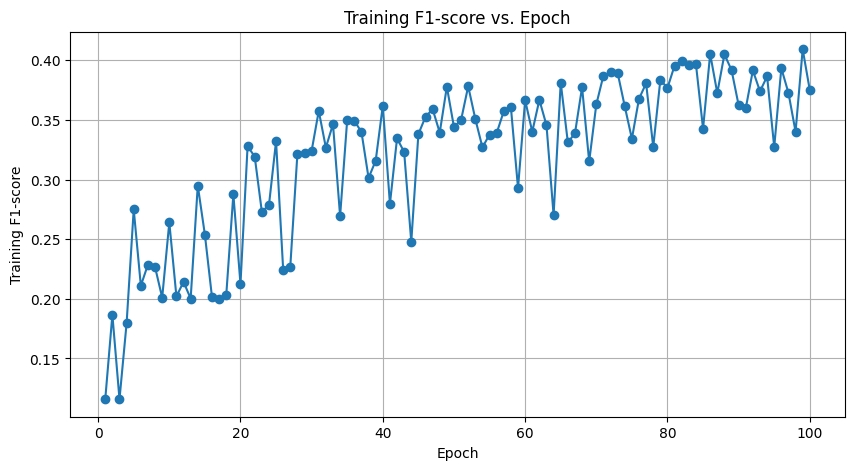

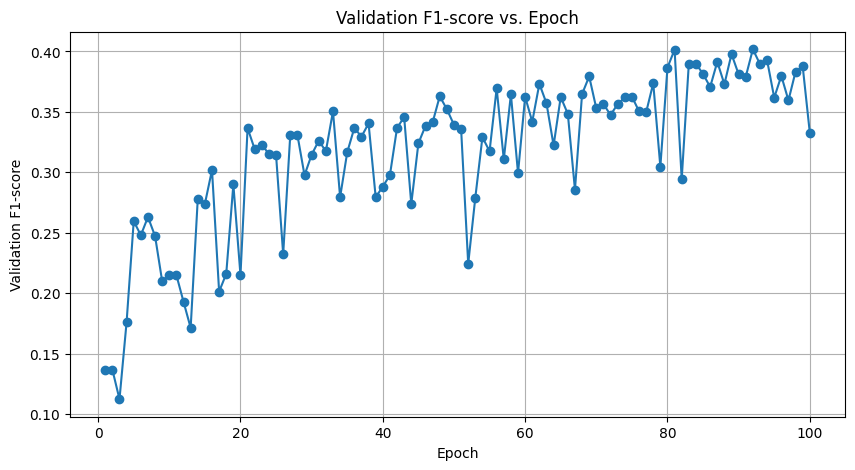

In [64]:
# Plotting Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o') # x-axis: epoch number (1 to num_epochs), y-axis: epoch_losses
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()

# Plotting Training F1-score vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_f1_scores, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training F1-score')
plt.title('Training F1-score vs. Epoch')
plt.grid(True)
plt.show()

# Plotting Validation F1-score vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation F1-score')
plt.title('Validation F1-score vs. Epoch')
plt.grid(True)
plt.show()

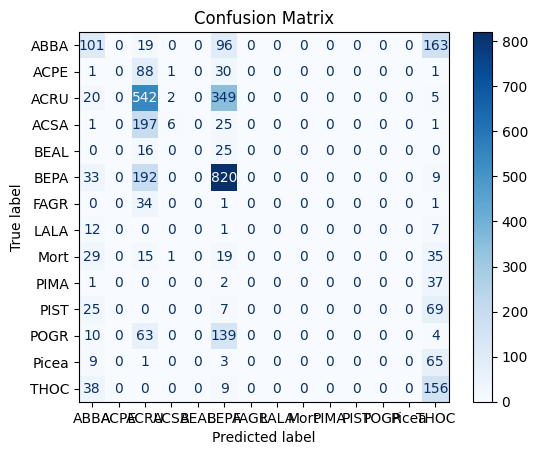

[101   0 542   6   0 820   0   0   0   0   0   0   0 156]


In [65]:
# Get predictions for the entire validation set
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

# Calculate confusion matrix
cm = confusion_matrix(y_val.cpu().numpy(), predicted.cpu().numpy(),labels=np.arange(len(label_encoder.classes_)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(np.diagonal(cm)) #Only ABBA, ACRU and THOC present TP

In [66]:
# Assuming y_true and y_pred are your true and predicted labels
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels


# Note: y_val is already on the CPU since it was used in the validation loop
f1 = f1_score(y_val, predicted.cpu(), average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4053


In [67]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are your true and predicted labels
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

report = classification_report(
        y_val,
        predicted.cpu(),
        target_names=label_encoder.classes_,
        labels=np.arange(len(label_encoder.classes_))  # All classes in the encoder
  )
print(report)

file_path = '/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/classification_reports/20241217_classification_report_100_epochs.txt'

with open(file_path, 'w') as f:
    report = classification_report(
        y_val,
        predicted.cpu(),
        target_names=label_encoder.classes_,
        labels=np.arange(len(label_encoder.classes_))
    )
    f.write(report)

print(f"Classification report saved to: {file_path}")

              precision    recall  f1-score   support

        ABBA       0.39      0.37      0.38       379
        ACPE       0.00      0.00      0.00       121
        ACRU       0.45      0.66      0.54       918
        ACSA       0.71      0.07      0.13       230
        BEAL       0.00      0.00      0.00        41
        BEPA       0.55      0.70      0.61      1054
        FAGR       0.00      0.00      0.00        36
        LALA       0.00      0.00      0.00        20
        Mort       0.00      0.00      0.00        99
        PIMA       0.00      0.00      0.00        40
        PIST       0.00      0.00      0.00       101
        POGR       0.00      0.00      0.00       216
       Picea       0.00      0.00      0.00        78
        THOC       0.31      0.68      0.43       203

    accuracy                           0.46      3536
   macro avg       0.17      0.18      0.15      3536
weighted avg       0.38      0.46      0.40      3536

Classification report sav

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m